### Test case LVV-T24: Verify implementation of Computing Derived Quantities

Verify that common derived quantities have been made available to end-users either as pre-computed columns or by providing functions that can be used dynamically in queries. These should at least include the ability to calculate the reduced chi-squared of fitted models and make it as easy as possible to calculate color-color diagrams.

**Discussion**: We will verify this requirement using the DP1 Qserv database, accessible via the TAP query service. 

In [1]:
import matplotlib.pyplot as plt

from lsst.rsp import get_tap_service

Instantiate the TAP service.

In [2]:
service = get_tap_service('tap')

Execute a spatial query on the DP1 `Object` table. The query statement itself demonstrates many of the required aspects, including:

- `scisql_nanojanskyToAbMag(g_psfFlux) AS gmag_psf`: apply a function to calculate the magnitude from the tabulated flux (note the similar function to calculate the magnitude error as well).
- `SELECT g_psfMag, g_psfMagErr, i_psfMag, r_psfMag`: select the PSF magnitudes, which are derived quantities based on the `{band}_psfFlux` columns. The magnitudes are not included in the Butler `object` table.
- `(g_psfMag-r_psfMag) as gr, (r_psfMag-i_psfMag) as ri`: calculate colors based on mathematical operations performed on the tabulated psfMag columns.
- `SELECT r_psfModel_TwoGaussian_chisq_reduced, coord_ra_dec_Cov`: select the reduced chi^2 of the double-Gaussian fit (from the `multiProFit` model fitting), and the covariance of the RA, Dec positions.
- `RADIANS(coord_ra) AS ra_rad, RADIANS(coord_dec) AS dec_rad`: apply a function to convert the RA, Dec positions to radians rather than their default units of degrees.
- `DISTANCE(POINT('ICRS', coord_ra, coord_dec), POINT('ICRS', 53.01, -28.35)) AS distance`: apply a function to calculate and return the distance of each query result (in degrees) from a given position.
- `r_psfFlux/r_psfFluxErr as r_snr`: calculate the signal-to-noise ratio ("SNR") based on a mathematical operation performed on two table columns.


In [3]:
query = """SELECT g_psfMag, 
       scisql_nanojanskyToAbMag(g_psfFlux) AS gmag_psf,
       scisql_nanojanskyToAbMagSigma(g_psfFlux, g_psfFluxErr) AS gmag_psf_err,
       g_psfMagErr, i_psfMag, r_psfMag,
       (g_psfMag-r_psfMag) as gr, (r_psfMag-i_psfMag) as ri,
       r_psfModel_TwoGaussian_chisq_reduced, coord_ra_dec_Cov,
       RADIANS(coord_ra) AS ra_rad,
       RADIANS(coord_dec) AS dec_rad,
       coord_dec, coord_ra,
       DISTANCE(POINT('ICRS', coord_ra, coord_dec), POINT('ICRS', 53.01, -28.35)) AS distance,
       scisql_nanojanskyToAbMag(g_sersicFlux) AS g_sersicMag,
       scisql_nanojanskyToAbMagSigma(g_sersicFlux, g_sersicFluxErr) AS g_sersicMagErr,
       r_psfFlux/r_psfFluxErr as r_snr
       FROM dp1.Object 
       WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),CIRCLE('ICRS', 53.01, -28.35, 0.1))=1
       AND refExtendedness < 0.5
       AND r_psfFlux/r_psfFluxErr > 50
"""

In [4]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'
results = job.fetch_result().to_table()

Job phase is COMPLETED


In [5]:
# Print the first 3 rows of the results table:
results[:3]

g_psfMag,gmag_psf,gmag_psf_err,g_psfMagErr,i_psfMag,r_psfMag,gr,ri,r_psfModel_TwoGaussian_chisq_reduced,coord_ra_dec_Cov,ra_rad,dec_rad,coord_dec,coord_ra,distance,g_sersicMag,g_sersicMagErr,r_snr
mag,,,mag,mag,mag,,,,deg**2,,,deg,deg,,,,
float32,float64,float64,float32,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64
23.136,23.13601686816002,0.005450925560937202,0.00545093,20.0397,21.7663,1.3696708679199219,1.726644515991211,0.592321,-1.18518e-17,0.9241413809761605,-0.49383155207097384,-28.29446372406175,52.9494008033255,0.07700632330234318,23.137624261913217,0.005448446110393201,542.5907531897379
18.1257,18.125674132577466,0.00017637348438338633,0.000176373,17.3746,17.567,0.5587062835693359,0.1923236846923828,0.528565,-4.83259e-19,0.9242170990359365,-0.49391934654476494,-28.29949397687455,52.953739128583585,0.07073594258240519,18.12935535412585,0.00015634826824295912,8143.1079851118275
23.7551,23.75512702822906,0.00967442659063095,0.00967443,22.7076,23.191,0.5641117095947266,0.4834136962890625,0.499711,-8.78973e-16,0.9242809022047275,-0.4938935654477951,-28.298016828826963,52.95739478087487,0.06961760664695911,23.753812257160295,0.009677170414057858,158.42507254116342


#### Compare the tabulated PSF magnitudes and the calculated values using the `scisql_nanojanskyToAbMag` function:

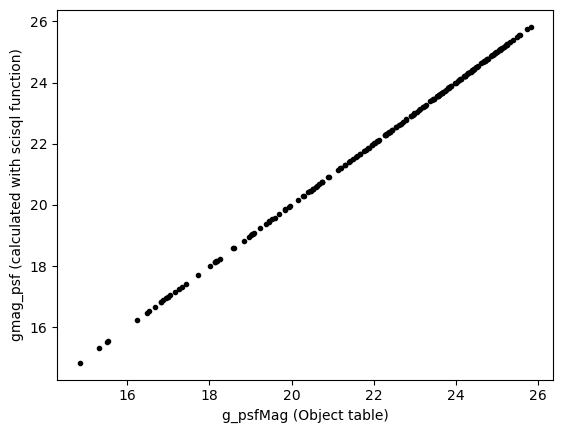

In [6]:
plt.plot(results['g_psfMag'], results['gmag_psf'], 'k.')
plt.xlabel('g_psfMag (Object table)')
plt.ylabel('gmag_psf (calculated with scisql function)')
plt.show()

We see that the magnitudes calculated via the function are the same as the tabulated (derived) magnitudes.

#### Plot a color-color diagram

Use the derived "gr" and "ri" colors.

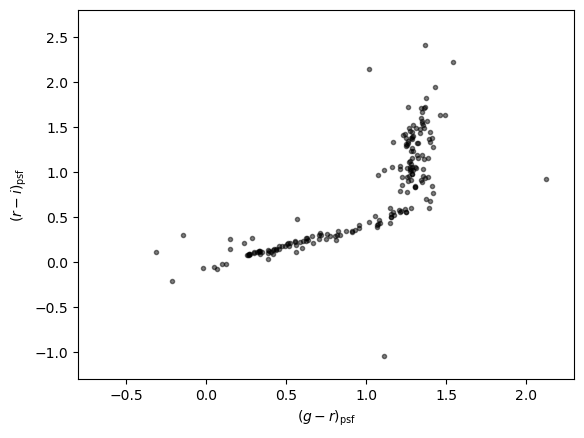

In [7]:
plt.plot(results['gr'], results['ri'], 'k.', alpha=0.5)
plt.xlim(-0.8, 2.3)
plt.ylim(-1.3, 2.8)
plt.xlabel(r'$(g-r)_{\rm psf}$')
plt.ylabel(r'$(r-i)_{\rm psf}$')
plt.show()

#### Run a similar query, but selecting extended objects

Apply the constraint `refExtendedness > 0.5` to select extended objects. Select model goodness-of-fit (chisq) values, positional covariances, and calculated magnitudes from the model-fit Sersic fluxes.

In [8]:
query = """SELECT coord_dec, coord_ra,
       r_psfModel_TwoGaussian_chisq_reduced, coord_ra_dec_Cov,
       scisql_nanojanskyToAbMag(g_sersicFlux) AS g_sersicMag,
       scisql_nanojanskyToAbMagSigma(g_sersicFlux, g_sersicFluxErr) AS g_sersicMagErr
       FROM dp1.Object 
       WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),CIRCLE('ICRS', 53.01, -28.35, 0.1))=1
       AND refExtendedness > 0.5
       AND r_psfFlux/r_psfFluxErr > 50
"""

In [9]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'
results = job.fetch_result().to_table()

Job phase is COMPLETED


#### Plot a histogram of the chi-squared values from the two Gaussian model fits:

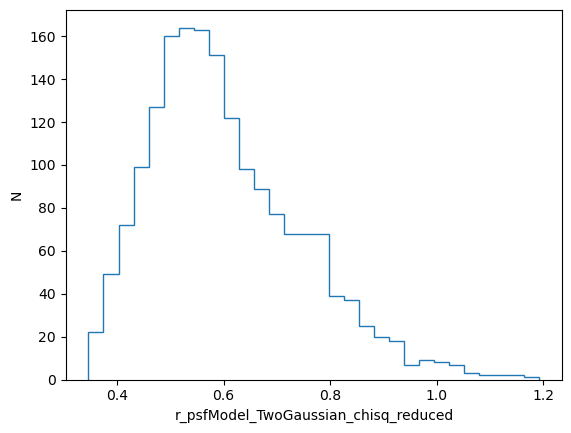

In [10]:
plt.hist(results['r_psfModel_TwoGaussian_chisq_reduced'], bins=30, histtype='step')
plt.xlabel('r_psfModel_TwoGaussian_chisq_reduced')
plt.ylabel('N')
plt.show()

#### Plot the position covariances as a function of Sersic magnitude:

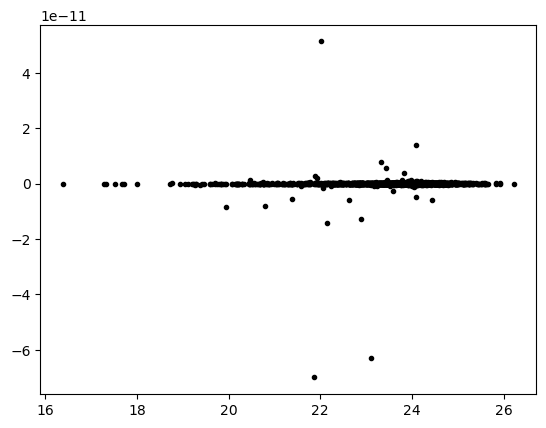

In [11]:
plt.plot(results['g_sersicMag'], results['coord_ra_dec_Cov'], 'k.')
plt.show()

### Results:

We have demonstrated that the DP1 `Object` table contains derived quantities that are not part of the Butler version of the `object` table. Additionally, we have shown various methods to calculate derived quantities via application of ADQL and mathematical functions to the table columns. We have thus demonstrated that the ability to retrieve derived quantities is provided by the TAP service; the result of this test is a **Pass**.